In [1]:
import numpy as np
import matplotlib.pyplot as plt
import polars as pl
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, IterableDataset
import torch.nn.functional as F
import chess
from tqdm import tqdm
import glob

torch.set_default_dtype(torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [2]:
MODEL_NUMBER = 2
MODEL_VERSION = 1

In [3]:
class EvalNet(nn.Module):
    """
    Neural network model for evaluating chess positions.

    This model takes a chess position as input and predicts the evaluation score
    for that position. It consists of convolutional and fully connected layers.

    Attributes:
        conv1 (nn.Conv2d): First convolutional layer.
        conv2 (nn.Conv2d): Second convolutional layer.
        fc1 (nn.Linear): First fully connected layer.
        fc2 (nn.Linear): Second fully connected layer.

    Methods:
        forward(x): Performs forward pass through the network.
    """

    def __init__(self) -> None:
        """
        Initializes the EvalNet class

        Args:
        - None

        Returns:
        - None
        """
        super(EvalNet, self).__init__()
        self.conv1 = nn.Conv2d(12, 16, kernel_size = 5, stride = 1, padding = 1)
        self.conv2 = nn.Conv2d(16, 24, kernel_size = 3, stride = 1, padding = 1) 
        self.fc1 = nn.Linear(24 * 6 * 6, 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Performs a forward pass through the network.

        Args:
        - x (torch.Tensor): Input tensor of shape (batch_size, 12, 8, 8)
        
        Returns:
        - torch.Tensor: Output tensor of shape (batch_size, 1)
        """
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.fc1(x))
        return self.fc2(x)  

In [4]:
def fen_str_to_3d_tensor(fen: str) -> torch.Tensor:
    """
    Converts a FEN string representation of a chess position to a 3D tensor.

    Args:
    - fen (str): The FEN string representing the chess position.

    Returns:
    - torch.Tensor: A 3D tensor representing the chess position, where each element
                    corresponds to a piece on the board.

    Example:
        fen = 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1'
        tensor = fen_str_to_3d_tensor(fen)
    """
    piece_to_int = {
        'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
        'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11,
    }

    board = np.zeros((12, 8, 8), dtype=np.float32)
    
    # Split the FEN string into parts ## 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1'
    fen_parts = fen.split(' ')
    fen_rows = fen_parts[0].split('/') # Only process the board position (the first part)
    
    for row_idx, row in enumerate(fen_rows):
        col_idx = 0
        for char in row:
            if char.isdigit():
                col_idx += int(char)
            else:
                piece = piece_to_int[char]
                board[piece, row_idx, col_idx] = 1
                col_idx += 1
    
    return torch.tensor(board)

In [5]:
path = "../Data/DataTrain"

letters_in = 'bcdefghijklmnopqrstuvwxyz'
letters_out = 'a'

csv_files_train = []
csv_files_val = []

for let in letters_in:
    csv_files_train.extend(glob.glob(f'{path}/Chess_Jan_{let}*'))
    csv_files_train.extend(glob.glob(f'{path}/Chess_Feb_{let}*'))
    csv_files_train.extend(glob.glob(f'{path}/Chess_Mar_{let}*')) # include in version 1-3
    # csv_files_train.extend(glob.glob(f'{path}/Chess_Apr_{let}*'))

for let_ in letters_out:
    csv_files_val.extend(glob.glob(f'{path}/Chess_Jan_{let_}*'))
    csv_files_val.extend(glob.glob(f'{path}/Chess_Feb_{let_}*'))
    csv_files_val.extend(glob.glob(f'{path}/Chess_Mar_{let_}*')) # include in version 1-3
    # csv_files_val.extend(glob.glob(f'{path}/Chess_Apr_{let_}*'))

In [6]:
def preprocess_inputs(DF: pl.DataFrame) -> torch.Tensor:
    """
    Proprocesses the input tensor into batches by applying the fen_str_to_3d_tensor function.
    """
    
    n_rows = DF.shape[0]

    inputs = torch.zeros(n_rows, 12, 8, 8)

    for i in range(n_rows):
        inputs[i] = fen_str_to_3d_tensor(DF['board'][i])
    
    return inputs

In [7]:
def Data(csv_file):
    
    df = pl.read_csv(csv_file, null_values=["None", "null", "#0", "#-0"])
    df = df.drop_nulls()

    df = df.with_columns(clip=pl.col("cp").clip(-10, 10))

    inputs = preprocess_inputs(df)
    targets = torch.tensor(df['cp'])

    return inputs, targets



class ChessIterableDataset(IterableDataset):
    def __init__(self, csv_files, chunksize=50000):
        """
        Initializes the ChessIterableDataset class.

        Args:
        - csv_files (list): List of CSV file paths.

        Returns:
        - None
        """
        self.csv_files = csv_files
        self.chunksize = chunksize

        
    def __len__(self):
        """
        Implements the length method.

        Returns:
        - int: Length of the dataset.
        """
        return sum(1 for _ in self.__iter__())


    def __iter__(self):
        """
        Implements the iterator logic.

        Returns:
        - Iterator object
        """
        return iter(self.csv_files)

In [8]:
def train(model, train_data_loader, val_data_loader, criterion, optimizer, num_epochs):
    """
    Trains model

    Parameters
    ----------
    model : torch.nn.Module
        model to be trained.
    train_data_loader : torch.utils.data.DataLoader
        training data.
    val_data_loader : torch.utils.data.DataLoader
        validation data.
    criterion : torch.nn.modules.loss._Loss
        loss function
    optimizer : torch.optim.Optimizer
        optimizer
    num_epochs : int
        Number of epochs

    Returns
    -------
    list
        average training loss for each epoch
    list
        average validation loss for each epoch

    """
    print(f'Begin Training! (on {device})')

    training_loss_history = []
    validation_loss_history = []

    try:
        for epoch in tqdm(range(num_epochs)):

            train_running_loss = 0.0
            val_running_loss = 0.0

            ## TRAINING PHASE =================================
            model.train()  # Set the model to training mode

            for i, csv_file in enumerate(csv_files_train):

                inputs, targets = Data(csv_file)

                inputs = inputs.to(device)
                targets = targets.to(device).unsqueeze(1)

                optimizer.zero_grad()
                train_outputs = model(inputs)
                train_batch_loss = criterion(train_outputs, targets)

                print(f"\t Training Batch Loss: {train_batch_loss}")

                train_batch_loss.backward()
                optimizer.step()

                train_running_loss += train_batch_loss.item()
            
            ## VALIDATION PHASE =================================
            model.eval()  # Set the model to evaluation mode
        
            with torch.no_grad():
                for i, csv_file in enumerate(csv_files_val):

                    inputs_val, targets_val = Data(csv_file)

                    inputs_val = inputs_val.to(device)
                    targets_val = targets_val.to(device).unsqueeze(1)
                    
                    val_outputs = model(inputs_val) # forward
                    val_batch_loss = criterion(val_outputs, targets_val)

                    print(f"\t Validation Batch Loss: {val_batch_loss}")

                    val_running_loss += val_batch_loss.item()

            print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_running_loss/len(csv_files_train):.5f}, Validation Loss: {val_running_loss/len(csv_files_val):.5f}')
            training_loss_history.append(train_running_loss/len(csv_files_train))
            validation_loss_history.append(val_running_loss/len(csv_files_val))
            
    except KeyboardInterrupt:
        print("Manual Stop: Finished Training Early!")
    finally:
        torch.save(model, f'models_autosave/autosave{MODEL_NUMBER}-{MODEL_VERSION}.pth')

    print(f'Finished Training!')

    return training_loss_history, validation_loss_history

In [9]:
model = EvalNet()
model = torch.load('models_autosave/autosave2-0.pth')
model = model.to(device)

criterion = nn.L1Loss() # nn.MSELoss()

optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.01)

train_loss_hist, valid_loss_hist = train(model, train_data_loader, val_data_loader, criterion, optimizer, num_epochs = 20)

Begin Training! (on cuda)


  0%|          | 0/20 [00:00<?, ?it/s]

	 Training Batch Loss: 2.701425552368164
	 Training Batch Loss: 2.844952344894409
	 Training Batch Loss: 2.478977918624878
	 Training Batch Loss: 2.7950637340545654
	 Training Batch Loss: 2.5609829425811768
	 Training Batch Loss: 2.7199442386627197
	 Training Batch Loss: 2.4520983695983887
	 Training Batch Loss: 2.622284412384033
	 Training Batch Loss: 2.526482582092285
	 Training Batch Loss: 2.6842849254608154
	 Training Batch Loss: 2.4676952362060547
	 Training Batch Loss: 2.532247304916382
	 Training Batch Loss: 2.674440622329712
	 Training Batch Loss: 2.5060136318206787
	 Training Batch Loss: 2.4860470294952393
	 Training Batch Loss: 2.550229549407959
	 Training Batch Loss: 2.5054118633270264
	 Training Batch Loss: 2.6299426555633545
	 Training Batch Loss: 2.5031967163085938
	 Training Batch Loss: 2.537966012954712
	 Training Batch Loss: 2.552461624145508
	 Training Batch Loss: 2.580718755722046
	 Training Batch Loss: 2.3462016582489014
	 Training Batch Loss: 2.404313802719116
	 Tr

  5%|▌         | 1/20 [2:59:46<56:55:50, 10786.85s/it]

	 Validation Batch Loss: 2.57541561126709
Epoch 1/20, Training Loss: 2.67769, Validation Loss: 2.48165
	 Training Batch Loss: 2.3950347900390625
	 Training Batch Loss: 2.351489305496216
	 Training Batch Loss: 2.365946054458618
	 Training Batch Loss: 2.4803714752197266
	 Training Batch Loss: 2.425581455230713
	 Training Batch Loss: 2.379659652709961
	 Training Batch Loss: 2.3457610607147217
	 Training Batch Loss: 2.409878969192505
	 Training Batch Loss: 2.418332815170288
	 Training Batch Loss: 2.4563841819763184
	 Training Batch Loss: 2.343881130218506
	 Training Batch Loss: 2.401711940765381
	 Training Batch Loss: 2.3890442848205566
	 Training Batch Loss: 2.4077744483947754
	 Training Batch Loss: 2.4058332443237305
	 Training Batch Loss: 2.367575168609619
	 Training Batch Loss: 2.4443888664245605
	 Training Batch Loss: 2.466879367828369
	 Training Batch Loss: 2.483909845352173
	 Training Batch Loss: 2.5920684337615967
	 Training Batch Loss: 2.4737157821655273
	 Training Batch Loss: 2.4

 10%|█         | 2/20 [5:12:22<45:36:26, 9121.48s/it] 

	 Validation Batch Loss: 2.6838974952697754
Epoch 2/20, Training Loss: 2.61802, Validation Loss: 2.58698
	 Training Batch Loss: 2.509474992752075
	 Training Batch Loss: 2.34860897064209
	 Training Batch Loss: 2.4088003635406494
	 Training Batch Loss: 2.49021053314209
	 Training Batch Loss: 2.486708402633667
	 Training Batch Loss: 2.4143989086151123
	 Training Batch Loss: 2.3526768684387207
	 Training Batch Loss: 2.421778917312622
	 Training Batch Loss: 2.4494712352752686
	 Training Batch Loss: 2.513418436050415
	 Training Batch Loss: 2.3650989532470703
	 Training Batch Loss: 2.435518980026245
	 Training Batch Loss: 2.3903884887695312
	 Training Batch Loss: 2.430020332336426
	 Training Batch Loss: 2.429682731628418
	 Training Batch Loss: 2.378255605697632
	 Training Batch Loss: 2.455355405807495
	 Training Batch Loss: 2.4297773838043213
	 Training Batch Loss: 2.4131057262420654
	 Training Batch Loss: 2.416315793991089
	 Training Batch Loss: 2.3472654819488525
	 Training Batch Loss: 2.41

 15%|█▌        | 3/20 [7:09:48<38:35:54, 8173.80s/it]

	 Validation Batch Loss: 2.528212308883667
Epoch 3/20, Training Loss: 2.56805, Validation Loss: 2.44609
	 Training Batch Loss: 2.371905565261841
	 Training Batch Loss: 2.582979440689087
	 Training Batch Loss: 2.55519700050354
	 Training Batch Loss: 2.5127081871032715
	 Training Batch Loss: 2.5884156227111816
	 Training Batch Loss: 2.439725637435913
	 Training Batch Loss: 2.4221184253692627
	 Training Batch Loss: 2.3851776123046875
	 Training Batch Loss: 2.499929428100586
	 Training Batch Loss: 2.5409061908721924
	 Training Batch Loss: 2.3712921142578125
	 Training Batch Loss: 2.4109046459198
	 Training Batch Loss: 2.406798839569092
	 Training Batch Loss: 2.3979415893554688
	 Training Batch Loss: 2.414118766784668
	 Training Batch Loss: 2.39546799659729
	 Training Batch Loss: 2.4368062019348145
	 Training Batch Loss: 2.4696476459503174
	 Training Batch Loss: 2.4094228744506836
	 Training Batch Loss: 2.3833489418029785
	 Training Batch Loss: 2.3599660396575928
	 Training Batch Loss: 2.58

 20%|██        | 4/20 [9:06:03<34:13:30, 7700.63s/it]

	 Validation Batch Loss: 2.476999044418335
Epoch 4/20, Training Loss: 2.54883, Validation Loss: 2.38288
	 Training Batch Loss: 2.2887377738952637
	 Training Batch Loss: 2.303797960281372
	 Training Batch Loss: 2.3348312377929688
	 Training Batch Loss: 2.412698745727539
	 Training Batch Loss: 2.39945387840271
	 Training Batch Loss: 2.3499114513397217
	 Training Batch Loss: 2.293800115585327
	 Training Batch Loss: 2.346400260925293
	 Training Batch Loss: 2.3774290084838867
	 Training Batch Loss: 2.4104859828948975
	 Training Batch Loss: 2.3126885890960693
	 Training Batch Loss: 2.3645448684692383
	 Training Batch Loss: 2.3473901748657227
	 Training Batch Loss: 2.3514597415924072
	 Training Batch Loss: 2.3790464401245117
	 Training Batch Loss: 2.3441567420959473
	 Training Batch Loss: 2.4423530101776123
	 Training Batch Loss: 2.4840071201324463
	 Training Batch Loss: 2.503486156463623
	 Training Batch Loss: 2.463308572769165
	 Training Batch Loss: 2.293588161468506
	 Training Batch Loss: 

 25%|██▌       | 5/20 [11:02:56<31:03:08, 7452.55s/it]

	 Validation Batch Loss: 2.7667644023895264
Epoch 5/20, Training Loss: 2.50578, Validation Loss: 2.66548
	 Training Batch Loss: 2.587759256362915
	 Training Batch Loss: 2.3558249473571777
	 Training Batch Loss: 2.3068723678588867
	 Training Batch Loss: 2.5394394397735596
	 Training Batch Loss: 2.456925392150879
	 Training Batch Loss: 2.4503679275512695
	 Training Batch Loss: 2.3148882389068604
	 Training Batch Loss: 2.363645076751709
	 Training Batch Loss: 2.346684694290161
	 Training Batch Loss: 2.4167532920837402
	 Training Batch Loss: 2.3699593544006348
	 Training Batch Loss: 2.4240057468414307
	 Training Batch Loss: 2.3595874309539795
	 Training Batch Loss: 2.337174654006958
	 Training Batch Loss: 2.380887031555176
	 Training Batch Loss: 2.317352294921875
	 Training Batch Loss: 2.385298728942871
	 Training Batch Loss: 2.342817783355713
	 Training Batch Loss: 2.3216333389282227
	 Training Batch Loss: 2.3671975135803223
	 Training Batch Loss: 2.300626516342163
	 Training Batch Loss: 

 30%|███       | 6/20 [13:00:08<28:25:35, 7309.70s/it]

	 Validation Batch Loss: 2.566426992416382
Epoch 6/20, Training Loss: 2.49188, Validation Loss: 2.44339
	 Training Batch Loss: 2.35922908782959
	 Training Batch Loss: 2.3148858547210693
	 Training Batch Loss: 2.3433358669281006
	 Training Batch Loss: 2.390073299407959
	 Training Batch Loss: 2.4331562519073486
	 Training Batch Loss: 2.325591564178467
	 Training Batch Loss: 2.310032606124878
	 Training Batch Loss: 2.3829727172851562
	 Training Batch Loss: 2.336968421936035
	 Training Batch Loss: 2.405457019805908
	 Training Batch Loss: 2.30307936668396
	 Training Batch Loss: 2.344755172729492
	 Training Batch Loss: 2.3482582569122314
	 Training Batch Loss: 2.336764097213745
	 Training Batch Loss: 2.34224534034729
	 Training Batch Loss: 2.2751216888427734
	 Training Batch Loss: 2.3980977535247803
	 Training Batch Loss: 2.3819851875305176
	 Training Batch Loss: 2.338052988052368
	 Training Batch Loss: 2.3411459922790527
	 Training Batch Loss: 2.2750635147094727
	 Training Batch Loss: 2.431

 35%|███▌      | 7/20 [14:56:32<26:00:40, 7203.15s/it]

	 Validation Batch Loss: 2.5134947299957275
Epoch 7/20, Training Loss: 2.44196, Validation Loss: 2.40178
	 Training Batch Loss: 2.338122606277466
	 Training Batch Loss: 2.2756457328796387
	 Training Batch Loss: 2.2816033363342285
	 Training Batch Loss: 2.3730082511901855
	 Training Batch Loss: 2.3643202781677246
	 Training Batch Loss: 2.2843010425567627
	 Training Batch Loss: 2.2415854930877686
	 Training Batch Loss: 2.3469083309173584
	 Training Batch Loss: 2.356851100921631
	 Training Batch Loss: 2.429203748703003
	 Training Batch Loss: 2.306150436401367
	 Training Batch Loss: 2.319669485092163
	 Training Batch Loss: 2.340636968612671
	 Training Batch Loss: 2.3018863201141357
	 Training Batch Loss: 2.3071908950805664
	 Training Batch Loss: 2.2753584384918213
	 Training Batch Loss: 2.351813793182373
	 Training Batch Loss: 2.357452630996704
	 Training Batch Loss: 2.315826654434204
	 Training Batch Loss: 2.3287880420684814
	 Training Batch Loss: 2.2329070568084717
	 Training Batch Loss:

 40%|████      | 8/20 [16:53:40<23:49:29, 7147.42s/it]

	 Validation Batch Loss: 2.757161855697632
Epoch 8/20, Training Loss: 2.44494, Validation Loss: 2.62066
	 Training Batch Loss: 2.5490846633911133
	 Training Batch Loss: 2.832127332687378
	 Training Batch Loss: 2.5412352085113525
	 Training Batch Loss: 2.896754264831543
	 Training Batch Loss: 2.635848045349121
	 Training Batch Loss: 2.7425754070281982
	 Training Batch Loss: 2.591015338897705
	 Training Batch Loss: 2.613662004470825
	 Training Batch Loss: 2.6535544395446777
	 Training Batch Loss: 2.6334927082061768
	 Training Batch Loss: 2.521604299545288
	 Training Batch Loss: 2.639061450958252
	 Training Batch Loss: 2.5090157985687256
	 Training Batch Loss: 2.6288042068481445
	 Training Batch Loss: 2.468815565109253
	 Training Batch Loss: 2.536160469055176
	 Training Batch Loss: 2.598726272583008
	 Training Batch Loss: 2.5199854373931885
	 Training Batch Loss: 2.551054000854492
	 Training Batch Loss: 2.4782938957214355
	 Training Batch Loss: 2.3755693435668945
	 Training Batch Loss: 2.

 45%|████▌     | 9/20 [19:21:36<23:29:25, 7687.80s/it]

	 Validation Batch Loss: 2.608593463897705
Epoch 9/20, Training Loss: 2.42791, Validation Loss: 2.50112
	 Training Batch Loss: 2.4160850048065186
	 Training Batch Loss: 2.408046245574951
	 Training Batch Loss: 2.2764530181884766
	 Training Batch Loss: 2.5095672607421875
	 Training Batch Loss: 2.3764097690582275
	 Training Batch Loss: 2.3771915435791016
	 Training Batch Loss: 2.3076891899108887
	 Training Batch Loss: 2.3166024684906006
	 Training Batch Loss: 2.3979406356811523
	 Training Batch Loss: 2.4041736125946045
	 Training Batch Loss: 2.284283399581909
	 Training Batch Loss: 2.364804744720459
	 Training Batch Loss: 2.34112286567688
	 Training Batch Loss: 2.3124287128448486
	 Training Batch Loss: 2.348527193069458
	 Training Batch Loss: 2.289278984069824
	 Training Batch Loss: 2.347104549407959
	 Training Batch Loss: 2.3348731994628906
	 Training Batch Loss: 2.31571626663208
	 Training Batch Loss: 2.327606439590454
	 Training Batch Loss: 2.2429990768432617
	 Training Batch Loss: 2.

 50%|█████     | 10/20 [22:38:26<24:53:23, 8960.32s/it]

	 Validation Batch Loss: 2.5314130783081055
Epoch 10/20, Training Loss: 2.42427, Validation Loss: 2.42125
	 Training Batch Loss: 2.3466038703918457
	 Training Batch Loss: 2.3079833984375
	 Training Batch Loss: 2.220128297805786
	 Training Batch Loss: 2.3506968021392822
	 Training Batch Loss: 2.3215930461883545
	 Training Batch Loss: 2.261986494064331
	 Training Batch Loss: 2.2470152378082275
	 Training Batch Loss: 2.2485673427581787
	 Training Batch Loss: 2.255559206008911
	 Training Batch Loss: 2.2976174354553223
	 Training Batch Loss: 2.2440788745880127
	 Training Batch Loss: 2.344174385070801
	 Training Batch Loss: 2.3349180221557617
	 Training Batch Loss: 2.2789065837860107
	 Training Batch Loss: 2.3093631267547607
	 Training Batch Loss: 2.270602226257324
	 Training Batch Loss: 2.3067710399627686
	 Training Batch Loss: 2.3126163482666016
	 Training Batch Loss: 2.3696277141571045
	 Training Batch Loss: 2.3626434803009033
	 Training Batch Loss: 2.18890118598938
	 Training Batch Loss:

 55%|█████▌    | 11/20 [25:56:24<24:37:58, 9853.14s/it]

	 Validation Batch Loss: 2.421844005584717
Epoch 11/20, Training Loss: 2.40919, Validation Loss: 2.32106
	 Training Batch Loss: 2.236826181411743
	 Training Batch Loss: 2.2527637481689453
	 Training Batch Loss: 2.2420618534088135
	 Training Batch Loss: 2.3287415504455566
	 Training Batch Loss: 2.341353416442871
	 Training Batch Loss: 2.252434015274048
	 Training Batch Loss: 2.181279420852661
	 Training Batch Loss: 2.2842445373535156
	 Training Batch Loss: 2.4069011211395264
	 Training Batch Loss: 2.353731632232666
	 Training Batch Loss: 2.2273528575897217
	 Training Batch Loss: 2.342623233795166
	 Training Batch Loss: 2.2666525840759277
	 Training Batch Loss: 2.2949132919311523
	 Training Batch Loss: 2.3761398792266846
	 Training Batch Loss: 2.307544231414795
	 Training Batch Loss: 2.313899278640747
	 Training Batch Loss: 2.322842597961426
	 Training Batch Loss: 2.3296780586242676
	 Training Batch Loss: 2.2800347805023193
	 Training Batch Loss: 2.259397029876709
	 Training Batch Loss: 

 60%|██████    | 12/20 [29:14:19<23:15:47, 10468.45s/it]

	 Validation Batch Loss: 2.693878412246704
Epoch 12/20, Training Loss: 2.40140, Validation Loss: 2.54259
	 Training Batch Loss: 2.443709373474121
	 Training Batch Loss: 2.4456708431243896
	 Training Batch Loss: 2.3052639961242676
	 Training Batch Loss: 2.528904438018799
	 Training Batch Loss: 2.5145487785339355
	 Training Batch Loss: 2.3969852924346924
	 Training Batch Loss: 2.40030837059021
	 Training Batch Loss: 2.3860740661621094
	 Training Batch Loss: 2.409790515899658
	 Training Batch Loss: 2.4593095779418945
	 Training Batch Loss: 2.3728408813476562
	 Training Batch Loss: 2.3947629928588867
	 Training Batch Loss: 2.3589441776275635
	 Training Batch Loss: 2.3632187843322754
	 Training Batch Loss: 2.3848941326141357
	 Training Batch Loss: 2.2712857723236084
	 Training Batch Loss: 2.384833812713623
	 Training Batch Loss: 2.4014317989349365
	 Training Batch Loss: 2.332195281982422
	 Training Batch Loss: 2.3999576568603516
	 Training Batch Loss: 2.2325329780578613
	 Training Batch Los

 65%|██████▌   | 13/20 [32:32:17<21:11:06, 10895.19s/it]

	 Validation Batch Loss: 2.880948781967163
Epoch 13/20, Training Loss: 2.39377, Validation Loss: 2.74997
	 Training Batch Loss: 2.6969540119171143
	 Training Batch Loss: 2.5657949447631836
	 Training Batch Loss: 2.6588997840881348
	 Training Batch Loss: 2.7434425354003906
	 Training Batch Loss: 2.633183479309082
	 Training Batch Loss: 2.62528395652771
	 Training Batch Loss: 2.4974873065948486
	 Training Batch Loss: 2.538037061691284
	 Training Batch Loss: 2.5583913326263428
	 Training Batch Loss: 2.6045589447021484
	 Training Batch Loss: 2.397212505340576
	 Training Batch Loss: 2.55063533782959
	 Training Batch Loss: 2.4652607440948486
	 Training Batch Loss: 2.520948648452759
	 Training Batch Loss: 2.423971652984619
	 Training Batch Loss: 2.437061309814453
	 Training Batch Loss: 2.471357583999634
	 Training Batch Loss: 2.4426345825195312
	 Training Batch Loss: 2.421534299850464
	 Training Batch Loss: 2.3616080284118652
	 Training Batch Loss: 2.2831900119781494
	 Training Batch Loss: 2.

 70%|███████   | 14/20 [35:50:02<18:38:49, 11188.23s/it]

	 Validation Batch Loss: 2.3977372646331787
Epoch 14/20, Training Loss: 2.35120, Validation Loss: 2.30076
	 Training Batch Loss: 2.235508441925049
	 Training Batch Loss: 2.203101396560669
	 Training Batch Loss: 2.2077815532684326
	 Training Batch Loss: 2.302493095397949
	 Training Batch Loss: 2.246615409851074
	 Training Batch Loss: 2.207700729370117
	 Training Batch Loss: 2.1988935470581055
	 Training Batch Loss: 2.284797430038452
	 Training Batch Loss: 2.239410877227783
	 Training Batch Loss: 2.303375482559204
	 Training Batch Loss: 2.2157459259033203
	 Training Batch Loss: 2.2012734413146973
	 Training Batch Loss: 2.322312593460083
	 Training Batch Loss: 2.3707327842712402
	 Training Batch Loss: 2.250075578689575
	 Training Batch Loss: 2.2235898971557617
	 Training Batch Loss: 2.3293371200561523
	 Training Batch Loss: 2.2722325325012207
	 Training Batch Loss: 2.300848960876465
	 Training Batch Loss: 2.3022921085357666
	 Training Batch Loss: 2.17220401763916
	 Training Batch Loss: 2.

 75%|███████▌  | 15/20 [39:08:01<15:49:43, 11396.61s/it]

	 Validation Batch Loss: 3.0983049869537354
Epoch 15/20, Training Loss: 2.88141, Validation Loss: 2.93999
	 Training Batch Loss: 2.8300769329071045
	 Training Batch Loss: 3.200361490249634
	 Training Batch Loss: 2.8396942615509033
	 Training Batch Loss: 3.211197853088379
	 Training Batch Loss: 3.0175704956054688
	 Training Batch Loss: 2.863635540008545
	 Training Batch Loss: 2.9552483558654785
	 Training Batch Loss: 2.8311705589294434
	 Training Batch Loss: 3.0716586112976074
	 Training Batch Loss: 2.9101197719573975
	 Training Batch Loss: 2.850076198577881
	 Training Batch Loss: 2.981074094772339
	 Training Batch Loss: 2.856367349624634
	 Training Batch Loss: 2.9000637531280518
	 Training Batch Loss: 2.9367151260375977
	 Training Batch Loss: 2.8252220153808594
	 Training Batch Loss: 2.919640064239502
	 Training Batch Loss: 2.8939428329467773
	 Training Batch Loss: 2.862963914871216
	 Training Batch Loss: 2.9039056301116943
	 Training Batch Loss: 2.78959321975708
	 Training Batch Loss:

 80%|████████  | 16/20 [42:25:44<12:49:07, 11536.80s/it]

	 Validation Batch Loss: 2.9393649101257324
Epoch 16/20, Training Loss: 2.82321, Validation Loss: 2.83649
	 Training Batch Loss: 2.752500295639038
	 Training Batch Loss: 3.312512159347534
	 Training Batch Loss: 2.9088571071624756
	 Training Batch Loss: 2.911062717437744
	 Training Batch Loss: 2.991199016571045
	 Training Batch Loss: 2.9831531047821045
	 Training Batch Loss: 2.7431516647338867
	 Training Batch Loss: 2.87520432472229
	 Training Batch Loss: 2.9407663345336914
	 Training Batch Loss: 2.8397140502929688
	 Training Batch Loss: 2.778808832168579
	 Training Batch Loss: 2.8714585304260254
	 Training Batch Loss: 2.85477614402771
	 Training Batch Loss: 2.78550124168396
	 Training Batch Loss: 2.806419610977173
	 Training Batch Loss: 2.705838441848755
	 Training Batch Loss: 2.763241767883301
	 Training Batch Loss: 2.816065549850464
	 Training Batch Loss: 2.7048356533050537
	 Training Batch Loss: 2.662963628768921
	 Training Batch Loss: 2.655829906463623
	 Training Batch Loss: 2.7271

 85%|████████▌ | 17/20 [45:43:21<9:41:39, 11633.25s/it] 

	 Validation Batch Loss: 2.569445848464966
Epoch 17/20, Training Loss: 2.63992, Validation Loss: 2.45413
	 Training Batch Loss: 2.3670966625213623
	 Training Batch Loss: 2.4350228309631348
	 Training Batch Loss: 2.438826084136963
	 Training Batch Loss: 2.4514927864074707
	 Training Batch Loss: 2.4798271656036377
	 Training Batch Loss: 2.4788496494293213
	 Training Batch Loss: 2.328248977661133
	 Training Batch Loss: 2.420447587966919
	 Training Batch Loss: 2.502051591873169
	 Training Batch Loss: 2.519646406173706
	 Training Batch Loss: 2.3701589107513428
	 Training Batch Loss: 2.4794504642486572
	 Training Batch Loss: 2.473520278930664
	 Training Batch Loss: 2.4140572547912598
	 Training Batch Loss: 2.3810832500457764
	 Training Batch Loss: 2.395930767059326
	 Training Batch Loss: 2.502657175064087
	 Training Batch Loss: 2.501042604446411
	 Training Batch Loss: 2.458418607711792
	 Training Batch Loss: 2.4214396476745605
	 Training Batch Loss: 2.3410682678222656
	 Training Batch Loss: 

 90%|█████████ | 18/20 [49:00:50<6:29:55, 11697.94s/it]

	 Validation Batch Loss: 2.7806215286254883
Epoch 18/20, Training Loss: 2.57783, Validation Loss: 2.65604
	 Training Batch Loss: 2.5969793796539307
	 Training Batch Loss: 2.466404438018799
	 Training Batch Loss: 2.479173421859741
	 Training Batch Loss: 2.575749158859253
	 Training Batch Loss: 2.5233237743377686
	 Training Batch Loss: 2.456846237182617
	 Training Batch Loss: 2.3825409412384033
	 Training Batch Loss: 2.4619505405426025
	 Training Batch Loss: 2.4568727016448975
	 Training Batch Loss: 2.498445510864258
	 Training Batch Loss: 2.3862855434417725
	 Training Batch Loss: 2.4263761043548584
	 Training Batch Loss: 2.4134576320648193
	 Training Batch Loss: 2.4301059246063232
	 Training Batch Loss: 2.4373738765716553
	 Training Batch Loss: 2.3782012462615967
	 Training Batch Loss: 2.44480037689209
	 Training Batch Loss: 2.426997661590576
	 Training Batch Loss: 2.4180588722229004
	 Training Batch Loss: 2.4294238090515137
	 Training Batch Loss: 2.3194079399108887
	 Training Batch Los

 95%|█████████▌| 19/20 [52:19:17<3:16:00, 11760.73s/it]

	 Validation Batch Loss: 3.278355836868286
Epoch 19/20, Training Loss: 2.51866, Validation Loss: 3.13674
	 Training Batch Loss: 3.04219651222229
	 Training Batch Loss: 2.745448112487793
	 Training Batch Loss: 2.906543254852295
	 Training Batch Loss: 3.077847480773926
	 Training Batch Loss: 2.9440221786499023
	 Training Batch Loss: 2.998992919921875
	 Training Batch Loss: 2.884784698486328
	 Training Batch Loss: 3.0068981647491455
	 Training Batch Loss: 3.0328259468078613
	 Training Batch Loss: 2.9763002395629883
	 Training Batch Loss: 3.010762929916382
	 Training Batch Loss: 3.0549778938293457
	 Training Batch Loss: 2.744366407394409
	 Training Batch Loss: 2.941836357116699
	 Training Batch Loss: 2.910039186477661
	 Training Batch Loss: 2.6260719299316406
	 Training Batch Loss: 2.904998779296875
	 Training Batch Loss: 2.7860512733459473
	 Training Batch Loss: 2.7766294479370117
	 Training Batch Loss: 2.8404998779296875
	 Training Batch Loss: 2.5554306507110596
	 Training Batch Loss: 2.

100%|██████████| 20/20 [55:41:20<00:00, 10024.01s/it]  

	 Validation Batch Loss: 2.4694106578826904
Epoch 20/20, Training Loss: 2.51208, Validation Loss: 2.37085
Finished Training!


In [10]:
torch.save(model, f'models_5_3/model{MODEL_NUMBER}-{MODEL_VERSION}.pth')

In [11]:
import pickle


with open('pickle/DL_2_5-3_train_loss_history.pkl', 'wb') as f:
    pickle.dump(train_loss_hist, f)

with open('pickle/DL_2_5-3_valid_loss_history.pkl', 'wb') as f:
    pickle.dump(valid_loss_hist, f)

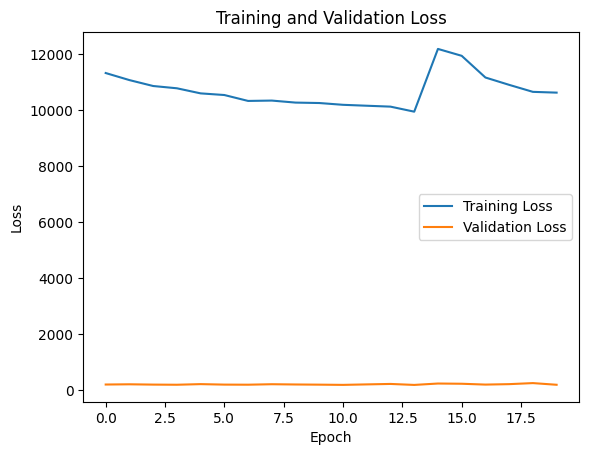

In [12]:
plt.figure()
plt.plot(train_loss_hist, label='Training Loss')
plt.plot(valid_loss_hist, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.savefig('figures/DL_2_5-3_loss_history.png')
plt.show()